# Virtual inertia scheduling

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scienceplots

import andes
import ams

# Configure logger
andes.config_logger(stream_level=30)
ams.config_logger(stream_level=20)

%run ../benchmarks.py
_ = get_tool_versions()

Last run time: 2025-02-02 09:17:11
Python: 3.12.0 | packaged by conda-forge | (main, Oct  3 2023, 08:36:57) [Clang 15.0.7 ]

Tool        Version
----------  -------
ltbams      1.0.3a1
andes       1.9.3  
cvxpy       1.6.0  
gurobipy    12.0.1 
mosek       11.0.5 
piqp        0.4.2  
pandapower  2.14.7 
numba       0.60.0 


In [2]:
%matplotlib inline

## Import cases

- Case1; no IBR: sp1, sa1
- Case2; IBR, no VIS: sp2, sa2
- Case3; IBR, VIS: sp3, sa3

In [3]:
sp1 = ams.load('./ieee39_uced.xlsx',
               setup=True,
               default=True,
               no_output=True)

sp2 = ams.load('./ieee39_uced_vis.xlsx',
               setup=True,
               default_config=True,
               no_output=True,)

sp3 = ams.load('./ieee39_uced_vis.xlsx',
               setup=True,
               default_config=True,
               no_output=True,)

Parsing input file "./ieee39_uced.xlsx"...
Input file parsed in 0.0385 seconds.
System set up in 0.0019 seconds.
Parsing input file "./ieee39_uced_vis.xlsx"...
Input file parsed in 0.0403 seconds.
System set up in 0.0018 seconds.
Parsing input file "./ieee39_uced_vis.xlsx"...
Input file parsed in 0.0404 seconds.
System set up in 0.0017 seconds.


Ensure PFlow models are identical.

In [4]:
for mdl_name in ['Bus', 'Line', 'PQ', 'Shunt', 'Slack', 'PV']:
    mdl_sp1 = sp1.models[mdl_name]
    mdl_sp2 = sp2.models[mdl_name]
    is_equal = mdl_sp1.as_df().equals(mdl_sp2.as_df())
    print(f'{mdl_name}: {is_equal}')

Bus: True
Line: True
PQ: True
Shunt: True
Slack: True
PV: True


## Solve scheduling

In [5]:
sp1.RTED.run(solver='CLARABEL')

Building system matrices
Parsing OModel for <RTED>
Evaluating OModel for <RTED>
Finalizing OModel for <RTED>
<RTED> initialized in 0.0310 seconds.
<RTED> solved as optimal in 0.0139 seconds, converged in 10 iterations with CLARABEL.


True

In [6]:
sp2.RTED.run(solver='CLARABEL')

Building system matrices
Parsing OModel for <RTED>
Evaluating OModel for <RTED>
Finalizing OModel for <RTED>
<RTED> initialized in 0.0097 seconds.
<RTED> solved as optimal in 0.0130 seconds, converged in 10 iterations with CLARABEL.


True

In [7]:
sp3.RTEDVIS.run(solver='CLARABEL')

Building system matrices
Parsing OModel for <RTEDVIS>
Evaluating OModel for <RTEDVIS>
Finalizing OModel for <RTEDVIS>
<RTEDVIS> initialized in 0.0115 seconds.
<RTEDVIS> solved as optimal in 0.0151 seconds, converged in 12 iterations with CLARABEL.


True

DC-AC conversion

In [8]:
sp1.RTED.dc2ac()

Parsing OModel for <ACOPF>
Evaluating OModel for <ACOPF>
Finalizing OModel for <ACOPF>
<ACOPF> initialized in 0.0036 seconds.
<ACOPF> solved in 0.4974 seconds, converged in 41 iterations with PYPOWER-PIPS.
<RTED> converted to AC.


True

In [9]:
sp2.RTED.dc2ac()

Parsing OModel for <ACOPF>
Evaluating OModel for <ACOPF>
Finalizing OModel for <ACOPF>
<ACOPF> initialized in 0.0176 seconds.
<ACOPF> solved in 0.5322 seconds, converged in 41 iterations with PYPOWER-PIPS.
<RTED> converted to AC.


True

In [10]:
sp3.RTEDVIS.dc2ac()

Parsing OModel for <ACOPF>
Evaluating OModel for <ACOPF>
Finalizing OModel for <ACOPF>
<ACOPF> initialized in 0.0040 seconds.
<ACOPF> solved in 0.5203 seconds, converged in 41 iterations with PYPOWER-PIPS.
<RTEDVIS> converted to AC.


True

Convert to dynamic cases.

In [11]:
sa1 = sp1.to_andes(setup=False, addfile='ieee39_sg.xlsx')

sa2 = sp2.to_andes(setup=False, addfile='ieee39_vis.xlsx')

sa3 = sp3.to_andes(setup=False, addfile='ieee39_vis.xlsx')

Generating code for 1 models on 12 processes.


Parsing additional file "ieee39_sg.xlsx"...
Following PFlow models in addfile will be overwritten: <Bus>, <PQ>, <PV>, <Slack>, <Shunt>, <Line>, <Area>
Addfile parsed in 0.0629 seconds.
System converted to ANDES in 0.2153 seconds.
AMS system 0x107b1f890 is linked to the ANDES system 0x35977e0f0.


Generating code for 1 models on 12 processes.


Parsing additional file "ieee39_vis.xlsx"...
Following PFlow models in addfile will be overwritten: <Bus>, <PQ>, <PV>, <Slack>, <Shunt>, <Line>, <Area>
Addfile parsed in 0.0633 seconds.
System converted to ANDES in 0.1435 seconds.
AMS system 0x3584f3a10 is linked to the ANDES system 0x3598a03e0.


Generating code for 1 models on 12 processes.


Parsing additional file "ieee39_vis.xlsx"...
Following PFlow models in addfile will be overwritten: <Bus>, <PQ>, <PV>, <Slack>, <Shunt>, <Line>, <Area>
Addfile parsed in 0.0592 seconds.
System converted to ANDES in 0.2997 seconds.
AMS system 0x358797500 is linked to the ANDES system 0x171eeae40.


In [12]:
# add Alter model as a load change at 1s
for ss in [sa1, sa2, sa3]:
    ss.add(model='Toggle', param_dict=dict(t=1, model='GENROU', dev='GENROU_3'))
    ss.setup()

Send dispatch results to dynamic cases.

In [13]:
sp1.dyn.send(adsys=sa1, routine='RTED')

Send <RTED> results to ANDES <0x35977e0f0>...
*Send <vBus> to StaticGen.v0
Send <vBus> to Bus.v0
Send <ug> to StaticGen.u
Send <pg> to StaticGen.p0


True

In [14]:
sp2.dyn.send(adsys=sa2, routine='RTED')

Send <RTED> results to ANDES <0x3598a03e0>...
*Send <vBus> to StaticGen.v0
Send <vBus> to Bus.v0
Send <ug> to StaticGen.u
Send <pg> to StaticGen.p0


True

In [15]:
sp3.dyn.send(adsys=sa3, routine='RTEDVIS')

Send <RTEDVIS> results to ANDES <0x171eeae40>...
*Send <vBus> to StaticGen.v0
Send <vBus> to Bus.v0
Send <ug> to StaticGen.u
Send <pg> to StaticGen.p0
Send <M> to RenGen.M
Send <D> to RenGen.D


True

## Run PFlow

In [16]:
# settings
for ss in [sa1, sa2, sa3]:
    ss.PQ.config.p2p = 1
    ss.PQ.config.q2q = 1
    ss.PQ.config.p2z = 0
    ss.PQ.config.q2z = 0
    ss.PQ.pq2z = 0

    ss.TDS.config.criteria = 0
    ss.TDS.config.tf = 30

In [17]:
sa1.PFlow.run()

True

In [18]:
sa2.PFlow.run()

True

In [19]:
sa3.PFlow.run()

True

## Run TDS

Run PFlow and TDS.

In [20]:
_ = sa1.TDS.init()

GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.012  | 0.001
 GENROU_2  | 0.042  | 0.036
 GENROU_3  | 0.036  | 0.003
 GENROU_4  | 0.025  | 0.001
 GENROU_5  | 0.050  | 0.001
 GENROU_7  | 0.031  | 0.002
 GENROU_8  | 0.029  | 0.006
 GENROU_9  | 0.018  | 0.001
 GENROU_10 | 0.003  | 0.000




In [21]:
sa1.TDS.run()

  0%|          | 0/100 [00:00<?, ?%/s]

<Toggle Toggle_2>: GENROU.GENROU_3 status changed to 0 at t=1.0 sec.


True

In [22]:
_ = sa2.TDS.init()

GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_2  | 0.042  | 0.036
 GENROU_3  | 0.036  | 0.003
 GENROU_4  | 0.025  | 0.001
 GENROU_5  | 0.050  | 0.001
 GENROU_7  | 0.031  | 0.002
 GENROU_10 | 0.003  | 0.000




In [23]:
sa2.TDS.run()

  0%|          | 0/100 [00:00<?, ?%/s]

<Toggle Toggle_2>: GENROU.GENROU_3 status changed to 0 at t=1.0 sec.


True

In [24]:
_ = sa3.TDS.init()

GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_2  | 0.042  | 0.036
 GENROU_3  | 0.036  | 0.003
 GENROU_4  | 0.025  | 0.001
 GENROU_5  | 0.050  | 0.001
 GENROU_7  | 0.031  | 0.002
 GENROU_10 | 0.003  | 0.000




In [25]:
sa3.TDS.run()

  0%|          | 0/100 [00:00<?, ?%/s]

<Toggle Toggle_2>: GENROU.GENROU_3 status changed to 0 at t=1.0 sec.


True

Receive dynamic results from TDS.

Generator outpus after frequency deviation are stored in `pg0` of `RTED` or `RTEDVIS`, which might be used in next round dispatch.

In [26]:
sp1.dyn.receive(adsys=sa1, routine='RTED')

Receive <ug> from SynGen.u
Receive <pg0> from SynGen.Pe
<RTED> reinit OModel due to non-parametric change.
Evaluating OModel for <RTED>
Finalizing OModel for <RTED>


True

In [27]:
sp2.dyn.receive(adsys=sa2, routine='RTED')

Receive <ug> from SynGen.u, RenGen.u
Receive <pg0> from SynGen.Pe, RenGen.Pe
<RTED> reinit OModel due to non-parametric change.
Evaluating OModel for <RTED>
Finalizing OModel for <RTED>


True

In [28]:
sp3.dyn.receive(adsys=sa3, routine='RTEDVIS')

Receive <ug> from SynGen.u, RenGen.u
Receive <pg0> from SynGen.Pe, RenGen.Pe
<RTEDVIS> reinit OModel due to non-parametric change.
Evaluating OModel for <RTEDVIS>
Finalizing OModel for <RTEDVIS>


True

## Results

In [29]:
print('Case 1, no IBR;',
      '\nM=', sa1.GENROU.M.v.sum().round(2),
      '; D=', sa2.GENROU.D.v.sum().round(2),
      '\nCost=', sp1.RTED.obj.v)
print('Case 2, IBR no VIS;',
      '\nM=', sa2.GENROU.M.v.sum().round(2) + sa2.REGCV1.M.v.sum().round(2),
      '; D=', sa2.GENROU.D.v.sum().round(2) + sa2.REGCV1.D.v.sum().round(2),
      '\nCost=', sp2.RTED.obj.v)
print('Case 3, IBR VIS;',
      '\nM=', sa3.GENROU.M.v.sum().round(2) + sa3.REGCV1.M.v.sum().round(2),
      '; D=', sa3.GENROU.D.v.sum().round(2) + sa3.REGCV1.D.v.sum().round(2),
      '\nCost=', sp3.RTEDVIS.obj.v)
print('Case3, IBR max;',
      '\nMmax=', sp3.REGCV1.Mmax.v.sum().round(2),
      '; Dsum=', sp3.REGCV1.Dmax.v.sum().round(2))

Case 1, no IBR; 
M= 817.47 ; D= 30.79 
Cost= None
Case 2, IBR no VIS; 
M= 817.47 ; D= 54.69 
Cost= None
Case 3, IBR VIS; 
M= 941.19 ; D= 75.78999999999999 
Cost= None
Case3, IBR max; 
Mmax= 562.2 ; Dsum= 47.8


In [30]:
# --- generator idx ---

gen_id = pd.DataFrame()

# StaticGen idx
stg_idx = sa2.REGCV1.gen.v + sa2.GENROU.gen.v
# Generator bus (should be identical for StaticGen and SynGen or RenGen)
gen_id['gen_bus'] = sp1.StaticGen.get(src='bus', attr='v', idx=stg_idx).astype(int)
gen_id['stg_idx'] = stg_idx

# Dynamic generator idx
gen_id['dyg_sp1'] = sa1.SynGen.find_idx(keys='gen', values=stg_idx)
sg_sp2 = pd.Series(sa2.GENROU.find_idx(keys='gen', values=stg_idx, allow_none=True, default=''))
reg_sp2 = pd.Series(sa2.REGCV1.find_idx(keys='gen', values=stg_idx, allow_none=True, default=''))
gen_id['dyg_sp2'] = sg_sp2 + reg_sp2

# --- generator power ---
gen_p = pd.DataFrame()
gen_p.index = gen_id['stg_idx']

# schedul power
gen_p['pg_sp1'] = sp1.RTED.get(src='pg', attr='v', idx=stg_idx)
gen_p['pg_sp2'] = sp2.RTED.get(src='pg', attr='v', idx=stg_idx)
gen_p['pg_sp3'] = sp3.RTEDVIS.get(src='pg', attr='v', idx=stg_idx)
gen_p[['pg_sp1', 'pg_sp2', 'pg_sp3']] *= sa1.config.mva  # scale from p.u. to MW

# reserve power (should be zero)
gen_p['pru_sp1'] = sp1.RTED.get(src='pru', attr='v', idx=stg_idx)
gen_p['pru_sp2'] = sp2.RTED.get(src='pru', attr='v', idx=stg_idx)
gen_p['pru_sp3'] = sp3.RTEDVIS.get(src='pru', attr='v', idx=stg_idx)

gen_p['prd_sp1'] = sp1.RTED.get(src='prd', attr='v', idx=stg_idx)
gen_p['prd_sp2'] = sp2.RTED.get(src='prd', attr='v', idx=stg_idx)
gen_p['prd_sp3'] = sp3.RTEDVIS.get(src='prd', attr='v', idx=stg_idx)

# --- generator reserve ---
gen_MD = pd.DataFrame()
gen_MD.index = gen_id['stg_idx']

# collect M and D
M_sp2 = []
D_sp2 = []
M_pu_coeff_sp2 = []
D_pu_coeff_sp2 = []
for id in gen_id['dyg_sp2']:
    if id in sa2.GENROU.idx.v:
        M_sp2.append(sa2.GENROU.get(src='M', attr='v', idx=id))
        D_sp2.append(sa2.GENROU.get(src='D', attr='v', idx=id))
        M_pu_coeff_sp2.append(sa2.GENROU.get(src='M', attr='pu_coeff', idx=id))
        D_pu_coeff_sp2.append(sa2.GENROU.get(src='D', attr='pu_coeff', idx=id))

    elif id in sa2.REGCV1.idx.v:
        M_sp2.append(sa2.REGCV1.get(src='M', attr='v', idx=id))
        D_sp2.append(sa2.REGCV1.get(src='D', attr='v', idx=id))
        M_pu_coeff_sp2.append(sa2.REGCV1.get(src='M', attr='pu_coeff', idx=id))
        D_pu_coeff_sp2.append(sa2.REGCV1.get(src='D', attr='pu_coeff', idx=id))

M_sp3 = []
D_sp3 = []
M_pu_coeff_sp3 = []
D_pu_coeff_sp3 = []
for id in gen_id['dyg_sp2']:
    if id in sa3.GENROU.idx.v:
        M_sp3.append(sa3.GENROU.get(src='M', attr='v', idx=id))
        D_sp3.append(sa3.GENROU.get(src='D', attr='v', idx=id))
        M_pu_coeff_sp3.append(sa3.GENROU.get(src='M', attr='pu_coeff', idx=id))
        D_pu_coeff_sp3.append(sa3.GENROU.get(src='D', attr='pu_coeff', idx=id))
    elif id in sa3.REGCV1.idx.v:
        M_sp3.append(sa3.REGCV1.get(src='M', attr='v', idx=id))
        D_sp3.append(sa3.REGCV1.get(src='D', attr='v', idx=id))
        M_pu_coeff_sp3.append(sa3.REGCV1.get(src='M', attr='pu_coeff', idx=id))
        D_pu_coeff_sp3.append(sa3.REGCV1.get(src='D', attr='pu_coeff', idx=id))

# convert to device base
M_sa1 = sa1.GENROU.get(src='M', attr='v', idx=gen_id['dyg_sp1'])
M_pu_coeff = sa1.GENROU.get(src='M', attr='pu_coeff', idx=gen_id['dyg_sp1'])
gen_MD['M_sp1'] = [M / coeff for M, coeff in zip(M_sa1, M_pu_coeff)]
gen_MD['M_sp2'] = [M / coeff for M, coeff in zip(M_sp2, M_pu_coeff_sp2)]
gen_MD['M_sp3'] = [M / coeff for M, coeff in zip(M_sp3, M_pu_coeff_sp3)]

D_sa1 = sa1.GENROU.get(src='D', attr='v', idx=gen_id['dyg_sp1'])
D_pu_coeff = sa1.GENROU.get(src='D', attr='pu_coeff', idx=gen_id['dyg_sp1'])
gen_MD['D_sp1'] = [D / coeff for D, coeff in zip(D_sa1, D_pu_coeff)]
gen_MD['D_sp2'] = [D / coeff for D, coeff in zip(D_sp2, D_pu_coeff_sp2)]
gen_MD['D_sp3'] = [D / coeff for D, coeff in zip(D_sp3, D_pu_coeff_sp3)]

In [31]:
gen_MD.round(2)

,M_sp1,M_sp2,M_sp3,D_sp1,D_sp2,D_sp3
stg_idx,,,,,,
PV_30,8.40,8.40,10.00,0.5,0.5,1.00
PV_35,6.96,6.96,10.00,0.5,0.5,1.00
PV_37,4.86,4.86,10.00,0.5,0.5,1.00
PV_38,6.90,6.90,8.34,0.5,0.5,0.83
PV_31,8.06,8.06,8.06,0.5,0.5,0.50
PV_32,7.16,7.16,7.16,0.5,0.5,0.50
PV_33,8.72,8.72,8.72,0.5,0.5,0.50
PV_34,5.20,5.20,5.20,0.5,0.5,0.50
PV_36,8.28,8.28,8.28,0.5,0.5,0.50


In [32]:
gen_id

,gen_bus,stg_idx,dyg_sp1,dyg_sp2
0,30,PV_30,GENROU_1,VSG_1
1,35,PV_35,GENROU_6,VSG_2
2,37,PV_37,GENROU_8,VSG_3
3,38,PV_38,GENROU_9,VSG_4
4,31,PV_31,GENROU_2,GENROU_2
5,32,PV_32,GENROU_3,GENROU_3
6,33,PV_33,GENROU_4,GENROU_4
7,34,PV_34,GENROU_5,GENROU_5
8,36,PV_36,GENROU_7,GENROU_7
9,39,Slack_39,GENROU_10,GENROU_10


In [33]:
# pru and prd are zero
pg_cols = ['pg_sp1', 'pg_sp2', 'pg_sp3']
gen_p[pg_cols].round(4)

,pg_sp1,pg_sp2,pg_sp3
stg_idx,,,
PV_30,0.0,0.0,0.0
PV_35,0.0,0.0,0.0
PV_37,0.0,0.0,0.0
PV_38,0.0,0.0,0.0
PV_31,0.0,0.0,0.0
PV_32,0.0,0.0,0.0
PV_33,0.0,0.0,0.0
PV_34,0.0,0.0,0.0
PV_36,0.0,0.0,0.0


Dynamic results

In [34]:
# --- index ---
vsg_stg = [sa2.REGCV1.gen.v[0]]
idx_vsg = sa2.REGCV1.find_idx(keys='gen', values=vsg_stg)
syg_vsg = sa1.GENROU.find_idx(keys='gen', values=vsg_stg)
bus_syg = sa1.SynGen.get(src='bus', attr='v', idx=syg_vsg)
a_vBus_syg = sa1.Bus.get(src='v', attr='a', idx=bus_syg)
a_aBus_syg = sa1.Bus.get(src='a', attr='a', idx=bus_syg)

# --- data for fig1 ---
uid_sg = sa1.SynGen.idx2uid(syg_vsg)
pe_case1 = sa1.dae.ts.y[:, sa1.GENROU.Pe.a[uid_sg]]
paux_case1 = pe_case1 - sa1.GENROU.p0.v[uid_sg]
paux_case1 *= sa1.config.mva

uid_vsg = sa2.REGCV1.idx2uid(idx_vsg)
pe_case2 = sa2.dae.ts.y[:, sa2.REGCV1.Pe.a[uid_vsg]]
pref_case2 = sa2.REGCV1.Pref.v[uid_vsg]
paux_case2 = pe_case2 - pref_case2
paux_case2 *= sa2.config.mva

pe_case3 = sa3.dae.ts.y[:, sa3.REGCV1.Pe.a[uid_vsg]]
pref_case3 = sa3.REGCV1.Pref.v[uid_vsg]
paux_case3 = pe_case3 - pref_case3
paux_case3 *= sa3.config.mva

v_case1 = sa1.dae.ts.y[:, sa1.GENROU.v.a[uid_sg]]
v_case2 = sa2.dae.ts.y[:, sa2.REGCV1.v.a[uid_vsg]]
v_case3 = sa3.dae.ts.y[:, sa3.REGCV1.v.a[uid_vsg]]

# --- data for fig2 ---
omega_case1 = sa1.dae.ts.y[:, sa1.COI.omega.a]
omega_case1 *= sa1.config.freq
omega_case2 = sa2.dae.ts.y[:, sa2.COI.omega.a]
omega_case2 *= sa2.config.freq
omega_case3 = sa3.dae.ts.y[:, sa3.COI.omega.a]
omega_case3 *= sa3.config.freq

a_rocof = 7
rocof_case1 = sa1.dae.ts.y[:, sa1.BusROCOF.Wf_y.a[a_rocof]]
rocof_case1 *= sa1.config.freq
rocof_case2 = sa2.dae.ts.y[:, sa2.BusROCOF.Wf_y.a[a_rocof]]
rocof_case2 *= sa2.config.freq
rocof_case3 = sa3.dae.ts.y[:, sa3.BusROCOF.Wf_y.a[a_rocof]]
rocof_case3 *= sa3.config.freq

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


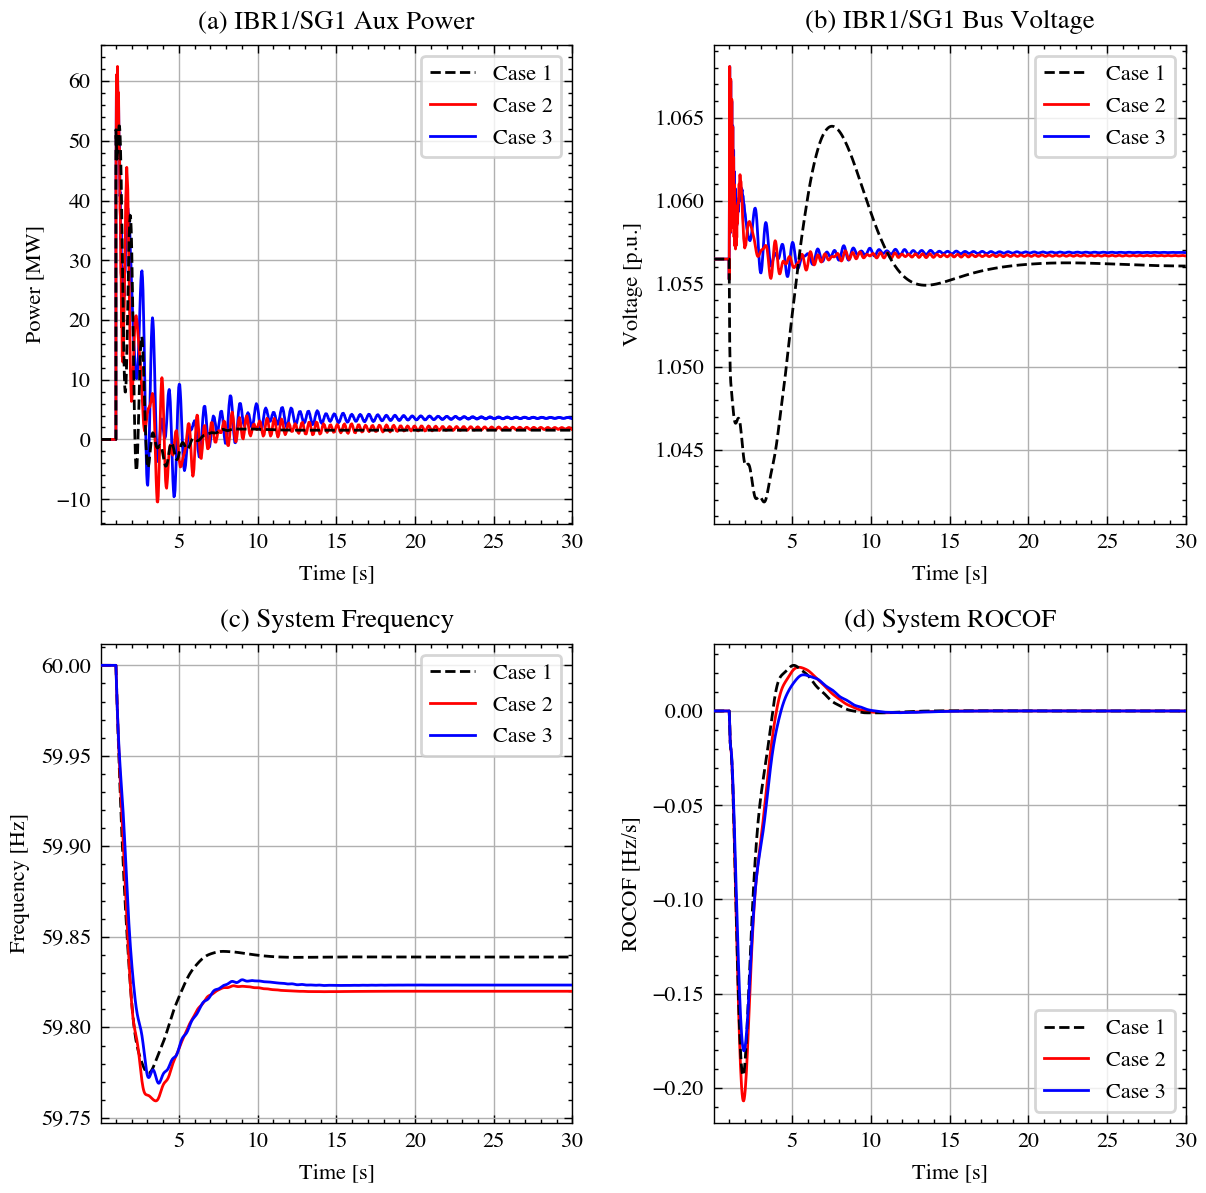

In [35]:
plt.style.use(['default', 'science', 'ieee'])
plt.rcParams['text.usetex'] = False

fig_v, ax_v = plt.subplots(2, 2, figsize=(7, 7), dpi=200)
fig_v.subplots_adjust(wspace=0.3, hspace=0.25)

ax_v[0, 0].plot(sa1.dae.ts.t, paux_case1,
                label='Case 1', zorder=10,
                linestyle='--')
ax_v[0, 0].plot(sa2.dae.ts.t, paux_case2,
                label='Case 2', zorder=9,
                linestyle='-')
ax_v[0, 0].plot(sa3.dae.ts.t, paux_case3,
                label='Case 3', zorder=8,
                linestyle='-')

ax_v[0, 1].plot(sa1.dae.ts.t, v_case1,
                label='Case 1', zorder=10,
                linestyle='--')
ax_v[0, 1].plot(sa2.dae.ts.t, v_case2,
                label='Case 2', zorder=9,
                linestyle='-')
ax_v[0, 1].plot(sa3.dae.ts.t, v_case3,
                label='Case 3', zorder=8,
                linestyle='-')

ax_v[1, 0].plot(sa1.dae.ts.t, omega_case1,
                label='Case 1', linestyle='--',
                zorder=10,)
ax_v[1, 0].plot(sa2.dae.ts.t, omega_case2,
                label='Case 2', linestyle='-',
                zorder=11,)
ax_v[1, 0].plot(sa3.dae.ts.t, omega_case3,
                label='Case 3', linestyle='-',
                zorder=12,)

ax_v[1, 1].plot(sa1.dae.ts.t, rocof_case1,
                label='Case 1', linestyle='--',
                zorder=10,)
ax_v[1, 1].plot(sa2.dae.ts.t, rocof_case2,
                label='Case 2', linestyle='-',
                zorder=9,)
ax_v[1, 1].plot(sa3.dae.ts.t, rocof_case3,
                label='Case 3', linestyle='-',
                zorder=11,)

_ = ax_v[0, 0].set_title('(a) IBR1/SG1 Aux Power')
_ = ax_v[0, 0].set_ylabel('Power [MW]')

_ = ax_v[0, 1].set_title('(b) IBR1/SG1 Bus Voltage')
_ = ax_v[0, 1].set_ylabel('Voltage [p.u.]')

_ = ax_v[1, 0].set_title('(c) System Frequency')
_ = ax_v[1, 0].set_ylabel('Frequency [Hz]')

_ = ax_v[1, 1].set_title('(d) System ROCOF')
_ = ax_v[1, 1].set_ylabel('ROCOF [Hz/s]')

for axes in ax_v.reshape(-1):
    axes.legend(frameon=True)
    axes.grid(True, zorder=0)
    axes.set_xlim([sa1.dae.ts.t[0], sa1.dae.ts.t[-1]])
    axes.set_xlabel('Time [s]')

fig_v.savefig("fig_vis_dyr.eps", format='eps')